In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class CrossEntropyLoss:
    @staticmethod
    def loss(y_pred, y_true):
        return -(y_true*np.log(y_pred)).sum()

    @staticmethod
    def loss_(y_pred, y_true):
        return -y_true/y_pred

class Sigmoid:
    @staticmethod
    def apply(x):
        return 1/(1+np.exp(-x))

    @staticmethod
    def apply_(x):
        # calculate the derivative of the sigmoid funciton
        return np.outer(x, (1 - x))
    
class Softmax:
    @staticmethod
    def apply(x):
        return np.exp(x)/(np.exp(x).sum())
    
    def apply_(x): 
        return np.eye(x.shape[0]) * x - np.outer(x, x)

In [3]:
class Layer:
    def __init__(self, weights, bias=None, activation_function=Sigmoid):
        self.weights = weights
        self.act_func = activation_function


    def apply(self, x_in):
        # calculate the layer output given x_in using layer weights and bias
        # save x_in and x_out for backwards pass
        x_out = np.dot(self.weights, x_in) #+ self.bias
        self.x_out = x_out
        self.x_in = x_in
        return self.act_func.apply(x_out)


In [4]:
class Network:
    # initialize the network with the given layers
    def __init__(self, layers=None, loss_func=CrossEntropyLoss):
        if layers is None:
            self.layers = []
        else:
            self.layers = layers
        self.check_size_layers()
        self.lossfunc = loss_func


    def forward(self, x):
        # do a forwark pass of the network on the given input
        x_out = self.layers[0].apply(x)
        for i in range(1, len(self.layers)):
            x_out = self.layers[i].apply(x_out)
        return x_out

    def forward_multiple_input(self, multiple_x):
        # performs multiple input
        multiple_x_out = []
        for j in range(len(multiple_x)):
            multiple_x_out.append(self.forward(multiple_x[j]))
        return multiple_x_out
    

    def check_size_layers(self):
        # check the correct sizes of weights between layers
        for i in range(1, len(self.layers)):
            if self.layers[i-1].weights.shape[0] != self.layers[i].weights.shape[1]:
                raise ValueError('Incorrect sizes of layers',
                                self.layers[i-1].weights.shape, 'vs', self.layers[i].weights.shape)


    def train(self, inputs, outputs, epochs=1, learning_rate=0.1):
        print('inputs', inputs.shape, 'outputs', outputs.shape)
        loss=0
        for epoch in range(epochs):
            loss=0
            for i_out in range(len(inputs)):            
                y_pred = np.array(self.forward(inputs[i_out]))
                loss = CrossEntropyLoss.loss(y_pred, outputs[i_out])
                loss_ = CrossEntropyLoss.loss_(y_pred, outputs[i_out])

                softmax_der = (np.eye(y_pred.shape[0]) * y_pred - np.outer(y_pred, y_pred))
                downstream_grad = loss_ @ softmax_der
                w3up = np.outer(downstream_grad, self.layers[2].x_in)

                sigmoid_der = np.outer(self.layers[2].x_in, (1 - self.layers[2].x_in ))
                downstream_grad = (downstream_grad @ self.layers[2].weights @ sigmoid_der)
                w2up = np.outer(downstream_grad, self.layers[1].x_in)

                sigmoid_der = np.outer(self.layers[1].x_in, (1 - self.layers[1].x_in ))
                downstream_grad = (downstream_grad @ self.layers[1].weights @ sigmoid_der)
                w1up = np.outer(downstream_grad, self.layers[0].x_in)

                loss += loss/inputs.shape[0] 

                self.layers[2].weights -= w3up * learning_rate
                self.layers[1].weights -= w2up * learning_rate
                self.layers[0].weights -= w1up * learning_rate

            if epoch %(epochs/10) == 0:
                print(epoch, 'CrossEntropyLoss', loss)

In [5]:
def calculate_accuracy(predict_proba, y):
    """
    Calculates the accuracy of the prediction
    :param predict_proba: the probabilities of each class
    :param y:  true labels
    :return: acc accuracy
    """
    y_pred = predict_proba.argmax(axis=1)
    acc = (y_pred == y).sum() / y.shape[0]
    return acc

In [6]:
train_df = pd.read_csv('archive/mnist_train.csv')

In [7]:
X = train_df.iloc[:, 1:]
assert not'label' in X.columns
X = X.to_numpy()
y = train_df['label']

In [8]:
X.shape

(60000, 784)

In [9]:
# Creating network
weights = np.random.normal(size=(300, X.shape[1]))/X.shape[1]
l1 = Layer(weights, None, Sigmoid)
weights = np.random.normal(size=(200, 300))/X.shape[1]
l2 = Layer(weights, None, Sigmoid)
weights = np.random.normal(size=(10, 200))/X.shape[1]
l3 = Layer(weights, None, Softmax)
net = Network([l1, l2, l3])

# Calculating accuracy
predict_proba = np.array(net.forward_multiple_input(X))
acc = calculate_accuracy(predict_proba, y)
print('Accuracy:', acc)

Accuracy: 0.09736666666666667


In [10]:
one_hots = []
for yi in y:
    one_hots.append([1 if _==yi else 0 for _ in range(10)])
one_hots = np.array(one_hots)

In [11]:
net.train(X[:1000], one_hots[:1000], 5, 0.0001)
predict_proba = np.array(net.forward_multiple_input(X))
acc = calculate_accuracy(predict_proba, y)
print('Accuracy:', acc)

inputs (1000, 784) outputs (1000, 10)
0 CrossEntropyLoss 2.328600808484841
1 CrossEntropyLoss 2.344138534380277


<ipython-input-2-398ccaff616a>:13: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


2 CrossEntropyLoss 2.3659026842924042
3 CrossEntropyLoss 2.3982523222765444
4 CrossEntropyLoss 2.4341850096790965
Accuracy: 0.10441666666666667


In [13]:
learning_rate = 0.01
learning_rate /= X.shape[0]
epochs = 5
for _ in range(epochs*X.shape[0]):
    row = np.random.randint(X.shape[0])
    y_pred = np.array(net.forward(X[row]))
    loss_ = CrossEntropyLoss.loss_(y_pred, one_hots[row])
    loss = CrossEntropyLoss.loss(y_pred, one_hots[row])

    softmax_der = (np.eye(y_pred.shape[0]) * y_pred - np.outer(y_pred, y_pred))
    downstream_grad = loss_ @ softmax_der
    w3up = np.outer(downstream_grad, l3.x_in)

    sigmoid_der = np.outer(l3.x_in, (1 - l3.x_in ))
    downstream_grad = (downstream_grad @ l3.weights @ sigmoid_der)
    w2up = np.outer(downstream_grad, l2.x_in)

    sigmoid_der = np.outer(l2.x_in, (1 - l2.x_in ))
    downstream_grad = (downstream_grad @ l2.weights @ sigmoid_der)
    w1up = np.outer(downstream_grad, l1.x_in)

    l1 = Layer(l1.weights - w1up*learning_rate, None, Sigmoid)
    l2 = Layer(l2.weights - w2up*learning_rate, None, Sigmoid)
    l3 = Layer(l3.weights - w3up*learning_rate, None, Softmax)
    net = Network([l1, l2, l3])
    
    if _ % 3000 == 0:
        print(_, loss)

0 2.0364842354659123


<ipython-input-2-398ccaff616a>:13: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


3000 2.227971571064735
6000 2.202462393300575
9000 2.0064708308066845
12000 2.4493336721443004
15000 2.485869876906077
18000 2.4716762551642057
21000 2.438414214821667
24000 1.8382797825267896
27000 2.4315655870483353
30000 2.0945711226077712
33000 2.4446026388250965
36000 2.4392274725735072
39000 2.0578890812746966
42000 2.1857798532130355
45000 2.1831883402280594
48000 2.431041129735351
51000 2.427262485359629
54000 1.9965623690321421
57000 2.4277814957399864
60000 1.8425869607422853
63000 2.4745463862920376
66000 2.4431906990181123
69000 2.483525164117176
72000 1.9910831158429945
75000 2.4738866346880024
78000 1.844522206373673
81000 2.0682519267356048
84000 1.9885169761165238
87000 2.42798926216092
90000 2.390344271468608
93000 2.183900603786315
96000 2.211653747697645
99000 2.207984416334086
102000 2.4432034248896084
105000 2.1944870953777897
108000 2.4438801276292437
111000 2.087758205386979
114000 2.398009059027584
117000 2.480874677635234
120000 2.444296675365494
123000 2.20291

# USING PYTORCH

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [43]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 10)
        
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=1.0)
#             module.weight.data.uniform_(-1, 1)
#             module.weight.data.fill_(0)
        elif isinstance(module, nn.LayerNorm):
            module.weight.data.fill_(0)


    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x


net = Net()

In [44]:
total_epochs = 20
batch = 64
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

losses_gauss = []
for epoch in range(total_epochs):  # loop over the dataset multiple times
    print("epoch: {}/{}".format(epoch, total_epochs))
    running_loss = 0.0
    for batch_i in range(0, X.shape[0], batch):
        inputs = torch.tensor(X[batch_i:batch_i + batch]).to(torch.float32)
        labels = torch.tensor(one_hots[batch_i:batch_i + batch]).to(torch.float32)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses_gauss.append(loss.item())
        loss.backward()
        optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if batch_i % 50000 == 0:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {batch_i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

print('Finished Training')

epoch: 0/20


<ipython-input-43-e2ba0363594b>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


epoch: 1/20
epoch: 2/20
epoch: 3/20
epoch: 4/20
epoch: 5/20
epoch: 6/20
epoch: 7/20
epoch: 8/20
epoch: 9/20
epoch: 10/20
epoch: 11/20
epoch: 12/20
epoch: 13/20
epoch: 14/20
epoch: 15/20
epoch: 16/20
epoch: 17/20
epoch: 18/20
epoch: 19/20
Finished Training


In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<ipython-input-43-e2ba0363594b>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


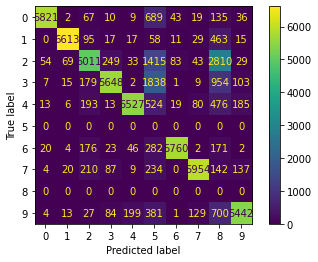

In [46]:
inputs = torch.tensor(X).to(torch.float32)
labels = torch.tensor(one_hots).to(torch.float32)

outputs = net(inputs)
cm = confusion_matrix(labels.argmax(axis=1), outputs.argmax(axis=1) , labels=[i for i in range(10)] ) # TODO check if labels are assigned correctly
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)]) # TODO check if labels are assigned correctly

disp.plot();

In [47]:
test_df = pd.read_csv('archive/mnist_test.csv')
X_test = test_df.iloc[:, 1:]
assert not'label' in X_test.columns
X_test = X_test.to_numpy()
y_test = test_df['label']

<ipython-input-43-e2ba0363594b>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


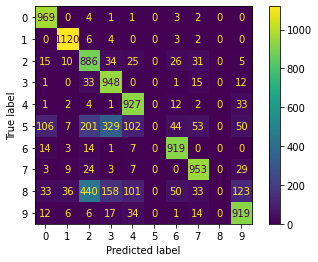

In [48]:
inputs_test = torch.tensor(X_test).to(torch.float32)

outputs_test = net(inputs_test)

cm = confusion_matrix(y_test, outputs_test.argmax(axis=1), labels=[i for i in range(10)] ) # TODO check if labels are assigned correctly
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)]) # TODO check if labels are assigned correctly

disp.plot();

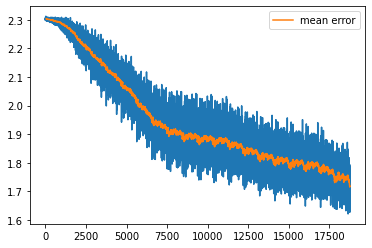

In [65]:
plt.figure()
plt.plot(losses_gauss)
plt.plot(losses_df['gauss'].rolling(window=50).mean(), label= 'mean error')
plt.legend()
plt.show();

In [ ]:
losses_df = pd.DataFrame([losses_gauss, losses_uniform, losses_zero], index=['gauss', 'uniform', 'zero']).T

mean_losses = losses_df.rolling(window=50).mean()
mean_losses.plot(title='mean losses for different weight initialization');

In [66]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 10)
        
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=1.0)
            module.weight.data.uniform_(-1, 1)
#             module.weight.data.fill_(0)
        elif isinstance(module, nn.LayerNorm):
            module.weight.data.fill_(0)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x


net = Net()

total_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

losses_uniform = []
for epoch in range(total_epochs):  # loop over the dataset multiple times
    print("epoch: {}/{}".format(epoch, total_epochs))
    running_loss = 0.0
    for batch_i in range(0, X.shape[0], batch):
        inputs = torch.tensor(X[batch_i:batch_i + batch]).to(torch.float32)
        labels = torch.tensor(one_hots[batch_i:batch_i + batch]).to(torch.float32)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses_uniform.append(loss.item())
        loss.backward()
        optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if batch_i % 50000 == 0:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {batch_i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

print('Finished Training')

epoch: 0/20


<ipython-input-66-13ad5b63645f>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


epoch: 1/20
epoch: 2/20
epoch: 3/20
epoch: 4/20
epoch: 5/20
epoch: 6/20
epoch: 7/20
epoch: 8/20
epoch: 9/20
epoch: 10/20
epoch: 11/20
epoch: 12/20
epoch: 13/20
epoch: 14/20
epoch: 15/20
epoch: 16/20
epoch: 17/20
epoch: 18/20
epoch: 19/20
Finished Training


<ipython-input-66-13ad5b63645f>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


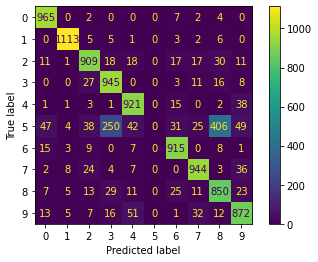

In [67]:
inputs_test = torch.tensor(X_test).to(torch.float32)

outputs_test = net(inputs_test)

cm = confusion_matrix(y_test, outputs_test.argmax(axis=1), labels=[i for i in range(10)] ) # TODO check if labels are assigned correctly
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)]) # TODO check if labels are assigned correctly

disp.plot();

In [68]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 10)
        
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=1.0)
#             module.weight.data.uniform_(-1, 1)
            module.weight.data.fill_(0)
#         elif isinstance(module, nn.LayerNorm):
#             module.weight.data.fill_(0)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x


net = Net()

total_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

losses_zero = []
for epoch in range(total_epochs):  # loop over the dataset multiple times
    print("epoch: {}/{}".format(epoch, total_epochs))
    running_loss = 0.0
    for batch_i in range(0, X.shape[0], batch):
        inputs = torch.tensor(X[batch_i:batch_i + batch]).to(torch.float32)
        labels = torch.tensor(one_hots[batch_i:batch_i + batch]).to(torch.float32)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses_zero.append(loss.item())
        loss.backward()
        optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if batch_i % 50000 == 0:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {batch_i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

print('Finished Training')

epoch: 0/20


<ipython-input-68-45b440c02247>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


epoch: 1/20
epoch: 2/20
epoch: 3/20
epoch: 4/20
epoch: 5/20
epoch: 6/20
epoch: 7/20
epoch: 8/20
epoch: 9/20
epoch: 10/20
epoch: 11/20
epoch: 12/20
epoch: 13/20
epoch: 14/20
epoch: 15/20
epoch: 16/20
epoch: 17/20
epoch: 18/20
epoch: 19/20
Finished Training


<ipython-input-68-45b440c02247>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


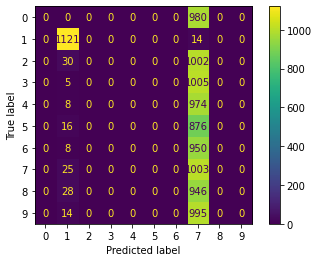

In [69]:
inputs_test = torch.tensor(X_test).to(torch.float32)

outputs_test = net(inputs_test)

cm = confusion_matrix(y_test, outputs_test.argmax(axis=1), labels=[i for i in range(10)] ) # TODO check if labels are assigned correctly
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)]) # TODO check if labels are assigned correctly

disp.plot();

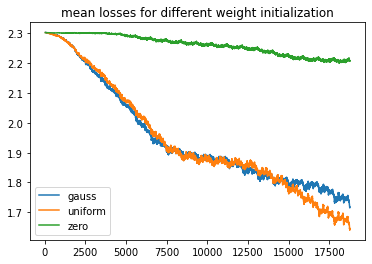

In [70]:
losses_df = pd.DataFrame([losses_gauss, losses_uniform, losses_zero], index=['gauss', 'uniform', 'zero']).T

mean_losses = losses_df.rolling(window=50).mean()
mean_losses.plot(title='mean losses for different weight initialization');
